In [1]:
# imports

import pandas as pd

from pymc_marketing import clv
from pymc_marketing.prior import Prior

import arviz as az
import matplotlib.pyplot as plt

### Data Import and Prep

In [2]:
rfm = pd.read_csv("../data/processed/rfm.csv")
print(f"RFM table shape: {rfm.shape}")
rfm.head()

RFM table shape: (2500, 5)


,household_key,RECENCY,FREQUENCY,MONETARY,HOUSEHOLD_AGE
0,1,6,86,4330.16,661
1,2,44,45,1954.34,609
2,3,9,47,2653.21,599
3,4,85,30,1200.11,608
4,5,9,40,779.06,627


In [3]:
# Rename columns to match expected modelling vriable inputs.
rfm = rfm.rename(columns={
    "household_key":"customer_id",
    "FREQUENCY":"frequency",
    "RECENCY": "recency",
    "HOUSEHOLD_AGE":"T",
    "MONETARY": "monetary_value"
})

In [4]:
bgnbd_data = rfm.drop(columns="monetary_value")
bgnbd_data.describe()

,customer_id,recency,frequency,T
count,2500.00000,2500.000000,2500.000000,2500.000000
mean,1250.50000,26.574000,110.593600,646.058800
std,721.83216,62.790655,115.669368,39.152355
min,1.00000,1.000000,1.000000,41.000000
25%,625.75000,2.000000,39.000000,617.000000
50%,1250.50000,7.000000,79.000000,643.000000
75%,1875.25000,21.000000,142.250000,676.000000
max,2500.00000,658.000000,1300.000000,711.000000


In [5]:
freq_cap = bgnbd_data["frequency"].quantile(0.95)
bgnbd_data = bgnbd_data.loc[bgnbd_data["frequency"] <= freq_cap]

In [6]:
bgnbd_data.describe()

,customer_id,recency,frequency,T
count,2376.000000,2376.000000,2376.000000,2376.000000
mean,1250.119529,27.761364,91.490741,645.817761
std,722.477798,64.153046,69.721798,39.385074
min,1.000000,1.000000,1.000000,41.000000
25%,622.750000,3.000000,37.000000,616.000000
50%,1248.500000,7.000000,73.000000,643.000000
75%,1876.250000,22.000000,131.000000,676.000000
max,2500.000000,658.000000,321.000000,711.000000


### Probabilistic Modelling

#### BGNBD model

In [7]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(
    frequency=bgnbd_data["frequency"].values,
    recency=bgnbd_data["recency"].values,
    T=bgnbd_data["T"].values,
)

bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.419555,0.009702,0.400539,0.438572
alpha,0.012793,0.000504,0.011806,0.013781
a,0.231397,0.005184,0.221236,0.241558
b,1.177643,0.031399,1.116100,1.239185


In [24]:
model_config = {
        "a_prior": Prior("Gamma", alpha=bgf.params_["a"] * 5, beta=5),
        "b_prior": Prior("Gamma", alpha=bgf.params_["b"] * 5, beta=5),
        "alpha_prior": Prior("Gamma", alpha=bgf.params_["alpha"] * 5, beta=5),
        "r_prior": Prior("Gamma", alpha=bgf.params_["r"] * 5, beta=5),
        "phi_dropout_prior": Prior("Gamma", alpha=1, beta=100),
        "kappa_dropout_prior": Prior("Gamma", alpha=1, beta=10)
}


In [25]:
# BG/NBD model
bgnbd_model = clv.BetaGeoModel(
    data = bgnbd_data,
    model_config=model_config
)

In [26]:
# Fit BG/NBD model
sample_kwargs = {
    "tune": 3000,
    "draws": 2000,
    "chains": 4,
    "target_accept": 0.99,
    "random_seed": 42,
    "init": "advi",
    "nuts":{
        "max_treedepth": 10
    } 
}

bgnbd_model.fit(nuts_sampler="numpyro",**sample_kwargs)

/home/nediff-nixon/miniconda3/envs/clv_predictive_env/lib/python3.10/site-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 5000/5000 [00:26<00:00, 192.06it/s, 31 steps of size 1.74e-01. acc. prob=0.99]


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data

In [27]:
# Summary fo training
bgnbd_model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.013,0.001,0.012,0.014,0.000,0.000,4096.0,4547.0,1.0
r,0.440,0.010,0.420,0.460,0.000,0.000,3958.0,4363.0,1.0
a,1.310,0.046,1.221,1.393,0.001,0.001,3208.0,3421.0,1.0
b,68.844,3.015,63.544,74.849,0.053,0.037,3260.0,4208.0,1.0


In [ ]:
# Save model results
bgnbd_model.save("../artifacts/probabilistic/pilot_results.nc")

Text(0.5, 0.98, 'BG/NBD Model Trace')

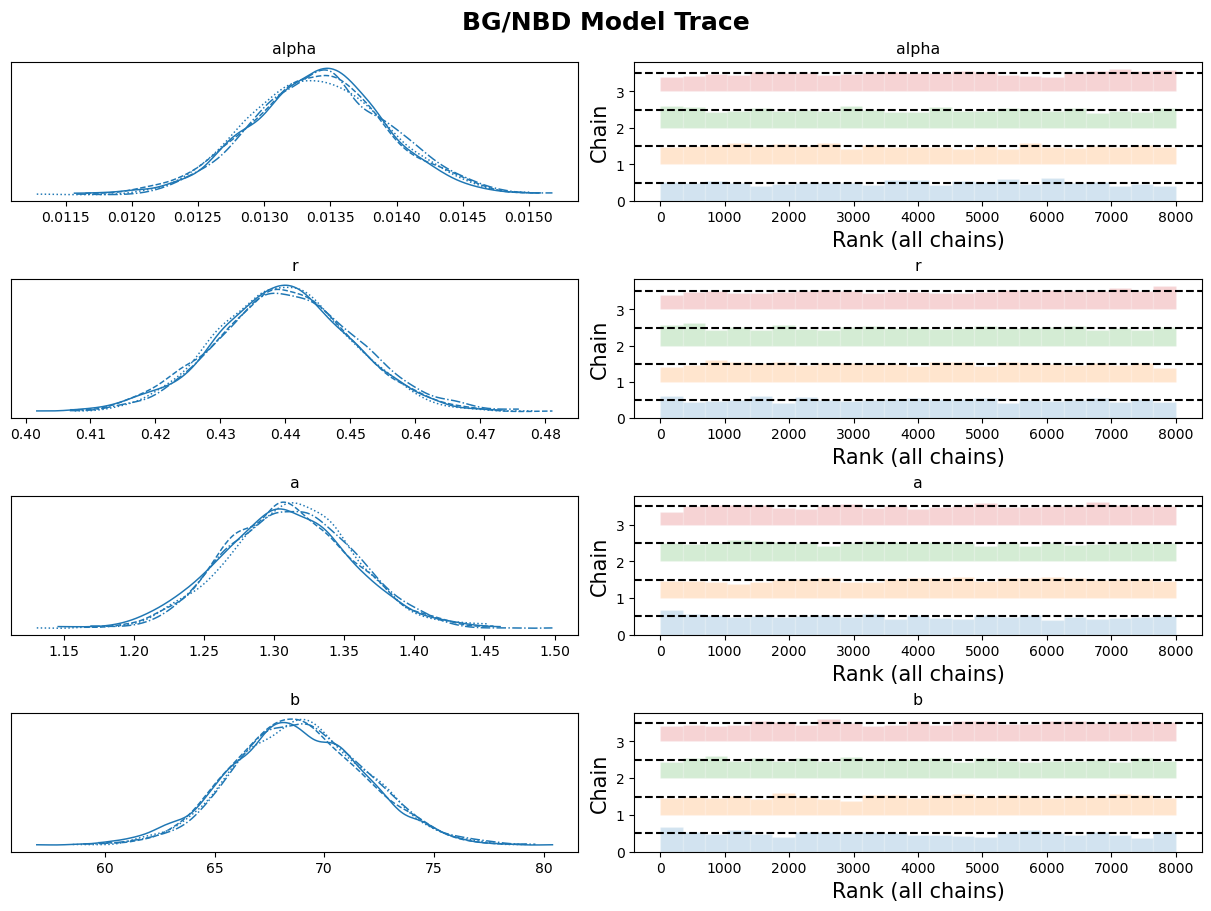

In [28]:
axes = az.plot_trace(
    data=bgnbd_model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("BG/NBD Model Trace", fontsize=18, fontweight="bold")

array([<Axes: title={'center': 'alpha'}>, <Axes: title={'center': 'r'}>,
       <Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>],
      dtype=object)

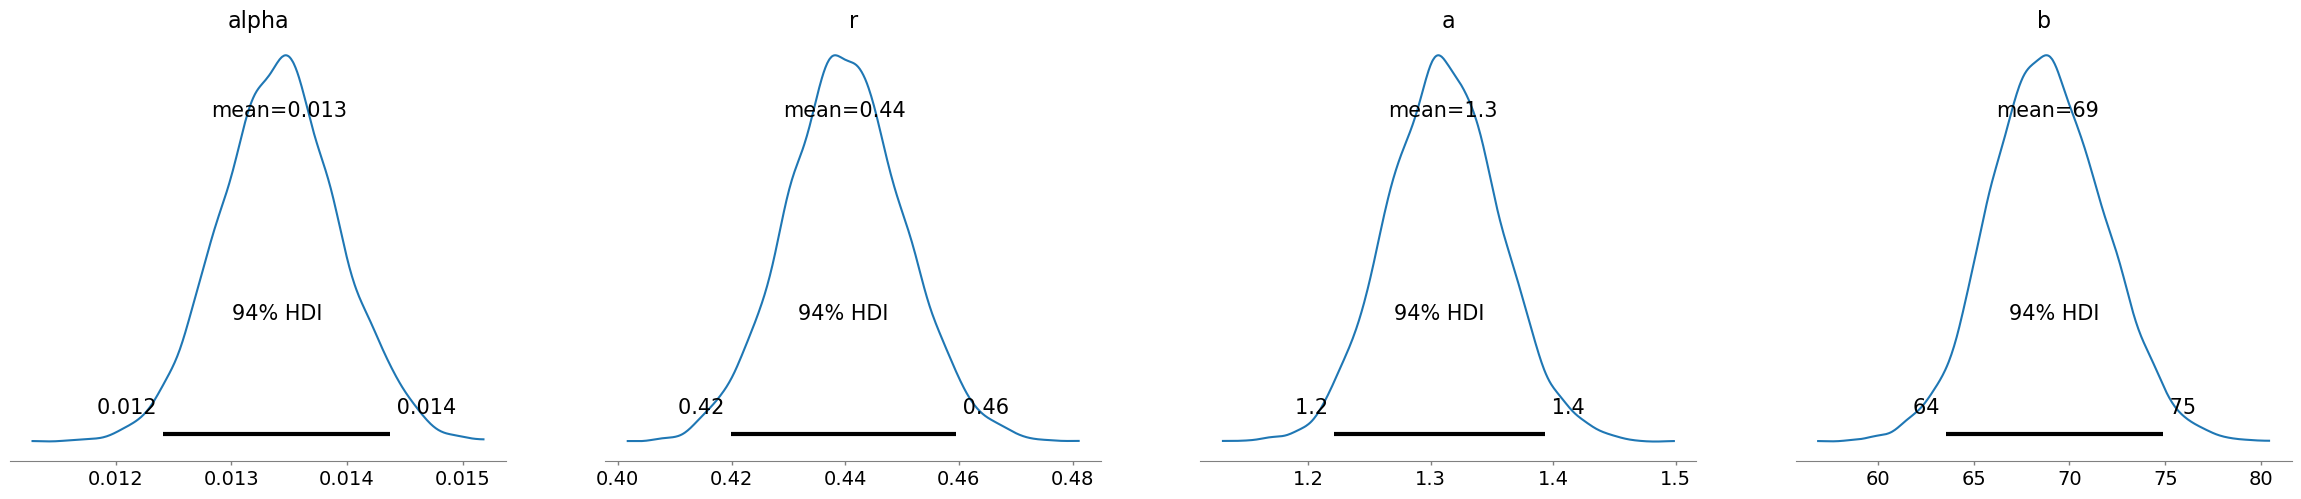

In [29]:
az.plot_posterior(bgnbd_model.fit_result)

Text(0.5, 0.98, 'BG/NBD Model Parameters')

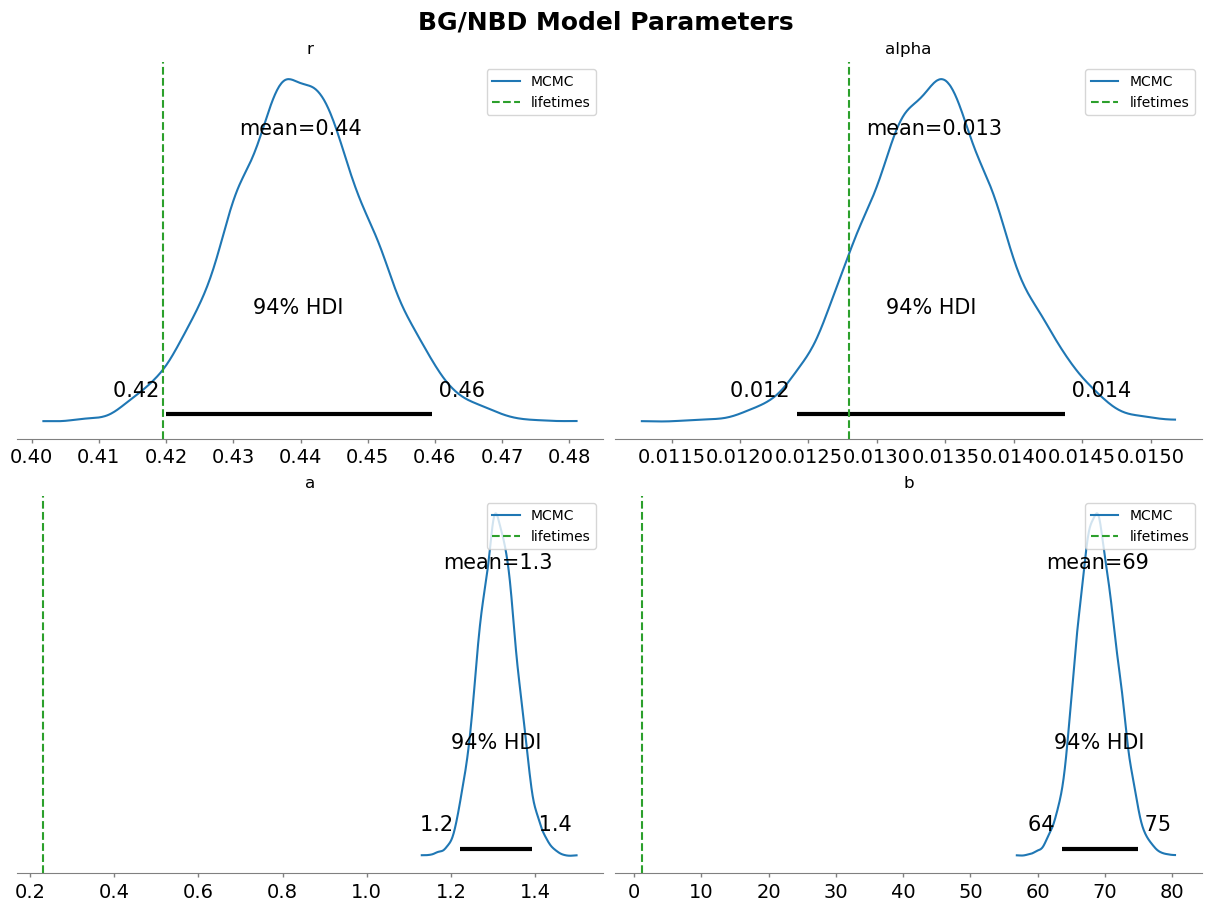

In [30]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 9), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for i, var_name in enumerate(["r", "alpha", "a", "b"]):
    ax = axes[i]
    az.plot_posterior(
        bgnbd_model.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        ax=ax,
        label="MCMC",
    )
    ax.axvline(
        x=bgf.summary["coef"][var_name], color="C2", linestyle="--", label="lifetimes"
    )
    ax.legend(loc="upper right")
    ax.set_title(var_name)

plt.gcf().suptitle("BG/NBD Model Parameters", fontsize=18, fontweight="bold")